In [1]:
import mpmath as mp
from sympy import *
init_printing()

# Context

We consider a QHO driven by a classical time-dependent force, whose time evolution is governed by
$$\hat{H}(t) = \frac{1}{2}\hat{q}^2 + \frac{1}{2}\hat{p}^2 - x(t)\hat{q}$$
One measures the position of the oscillator at a regular time interval $\tau$, i.e. at times $t_1 = \tau, t_2 = 2\tau, \ldots$
From the resulting position measurements $q_1, q_2, \ldots$, one wants to estimate the time-dependent force $x(t)$. Since $\hat{q}''(t) + \hat{q}(t) = x(t)$. If one had continuous measurements of the position $\widetilde{q}(t)$, one may therefore try to estimate $x(t)$ by $\widetilde{q}''(t) + \widetilde{q}(t)$. Since one only has discrete measurements, the second derivative must be replaced by a finite difference. For instance, using a symmetric finite difference involving 3 points, an estimate of $x(t_j)$ would be:
$$\frac{q_{j - 1} - 2q_j + q_{j + 1}}{\tau^2} + q_j = \frac{q_{j - 1} + (\tau^2 - 2)q_j + q_{j + 1}}{\tau^2}$$
More generally, the finite difference may involve $2p + 1$ points ($p \geq 1$), in which case the estimator would read:
$$\frac{\sum_{k = 1}^pc^{(p)}_k\left(q_{j + k} + q_{j - k}\right) + \left(\tau^2 + c^{(p)}_0\right)q_j}{\tau^2}$$
where $c^{(p)}_0, \ldots, c^{(p)}_p$ are coefficients depending on $p$ (see https://en.wikipedia.org/wiki/Finite_difference_coefficient ). The following holds:
$$
\begin{align*}
    c^{(p)}_k & = -\frac{2(-1)^kn!^2}{k^2(n - k)!(n + k)!} \quad 1 \leq k \leq p\\
    c^{(p)}_0 & = -2\sum_{k = 1}^pc^{(p)}_k
\end{align*}
$$

The variance of this estimator may be computed. The measurement imprecision and backaction contributions read:
$$
\begin{align*}
    & \frac{1}{\tau^4}\left[\frac{1}{4}\left(\sum_{1 \leq k \leq p}\left(c^{(p)}_k\right)^2\left(\frac{1}{\sigma_{j + k}^2} + \frac{1}{\sigma_{j - k}^2}\right) + \frac{\left(\tau^2 + c^{(p)}_0\right)^2}{\sigma_j^2}\right)\right.\\
    %
    & \qquad + \sum_{1 \leq n \leq j - p - 1}\left(\left(\tau^2 + c^{(p)}_0\right)k_{j, n} + \sum_{1 \leq l \leq p}c^{(p)}_l\left(k_{j - l, n} + k_{j + l, n}\right)\right)\sigma_n^2\\
    %
    & \left.\qquad + \sum_{j - p \leq n \leq j + p - 1}\left(\sum_{n + 1 \leq l \leq j + p}c^{(p)}_{|l - j|}k_{l, n}\right)^2\sigma_n^2\right]
\end{align*}
$$

We call "the boundary terms" the quantity:
$$\frac{1}{\tau}\left[\frac{1}{4}\left(\left(c^{(p)}_p\right)^2\frac{1}{\sigma_{j - p}^2} + \sum_{1 \leq k \leq p - 1}\left(c^{(p)}_k\right)^2\left(\frac{1}{\sigma_{j + k}^2} + \frac{1}{\sigma_{j - k}^2}\right) + \frac{\left(\tau^2 + c^{(p)}_0\right)^2}{\sigma_j^2}\right) + \sum_{j - p \leq n \leq j + p - 1}\left(\sum_{n + 1 \leq l \leq j + p}c^{(p)}_{|l - j|}k_{l, n}\right)^2\sigma_n^2\right]$$

We expect it to be lower-bounded by a constant, as can be easily verified for $p = 1$.

# Routines

Coefficients for finite-dimensional approximation of second derivative

In [2]:
def fd_2_coeffs(n):
    right_coeffs = [ -2 * (-1) ** k * factorial(n) ** 2 / (k ** 2 * factorial(n + k) * factorial(n - k)) for k in range(1, n + 1) ]
    return right_coeffs[::-1] + [ -2 * sum(right_coeffs) ] + right_coeffs

Compute coefficients of $\sigma_j^2$ ("boundary terms")

In [3]:
def boundary_sigma_sq_coefficients(fd_order, tau):
    fd_coeffs = fd_2_coeffs(fd_order)
    return [
        fd_coeffs[i] ** 2 / 4
        for i in range(0, 2 * fd_order)
    ], [
        sum([ ((tau ** 2 if j == fd_order else 0) + fd_coeffs[j]) * sin(-(j - i + 1) * tau) for j in range(i, 2 * fd_order + 1) ]) ** 2
        for i in range(1, 2 * fd_order + 1)
    ]

def numeric_boundary_sigma_sq_coefficients(fd_order, tau):
    fd_coeffs = [ mp.mpf(fd_coeff) for fd_coeff in fd_2_coeffs(fd_order) ]
    return [
        fd_coeffs[i] ** 2 / 4
        for i in range(0, 2 * fd_order)
    ], [
        sum([ ((tau ** 2 if j == fd_order else 0) + fd_coeffs[j]) * mp.sin(-(j - i + 1) * tau) for j in range(i, 2 * fd_order + 1) ]) ** 2
        for i in range(1, 2 * fd_order + 1)
    ]

Deduce lower bound for the contribution of boundary terms (optimizing over all $\sigma_j$)

In [4]:
def boundary_sigma_sq_lower_bound(fd_order, tau):
    return sum([ 2 * mp.sqrt(a * b) for (a, b) in zip(*numeric_boundary_sigma_sq_coefficients(fd_order, tau)) ]) / tau

# Tests

### Finite-difference coefficients. See http://web.media.mit.edu/~crtaylor/calculator.html for comparison.

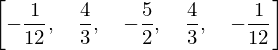

In [5]:
fd_2_coeffs(2)

### Lower bound for the contribution of the boundary terms

Symbolic coefficients

In [6]:
tau = Symbol("\\tau")

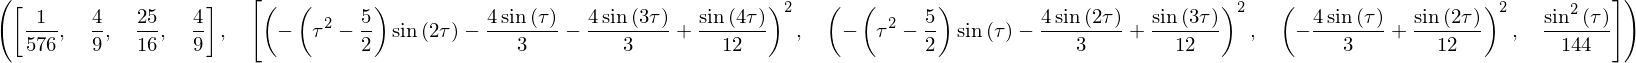

In [7]:
boundary_sigma_sq_coefficients(2, tau)

Numeric coefficients

In [8]:
numeric_boundary_sigma_sq_coefficients(2, 0.5)

([mpf('0.001736111111111111'),
  mpf('0.44444444444444442'),
  mpf('1.5625'),
  mpf('0.44444444444444442')],
 [mpf('2.0410567596640563e-8'),
  mpf('0.0015896751904158327'),
  mpf('0.32388786460825675'),
  mpf('0.0015961725490689592')])

In [9]:
list(zip(*numeric_boundary_sigma_sq_coefficients(2, 0.5)) )

[(mpf('0.001736111111111111'), mpf('2.0410567596640563e-8')),
 (mpf('0.44444444444444442'), mpf('0.0015896751904158327')),
 (mpf('1.5625'), mpf('0.32388786460825675')),
 (mpf('0.44444444444444442'), mpf('0.0015961725490689592'))]

Lower bound

In [10]:
boundary_sigma_sq_lower_bound(1, 0.01)

mpf('1.9999666676666497')

In [11]:
boundary_sigma_sq_lower_bound(10, 0.01)

mpf('4.9590594279604119')

In [12]:
boundary_sigma_sq_lower_bound(100, 0.01)

mpf('5.6354146018292761')

In [ ]:
boundary_sigma_sq_lower_bound(500, 0.01)